In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from torcheval.metrics.functional import r2_score
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
from Distances import Distances
sys.path.insert(1,'../code/data_utils/')
from HiCMap import HiCMap
from HiCDataset import HiCDataset
from ConfigDataset import ConfigDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
resolution = 20_000
data_dir = '../data/samples/origami_64_no_embed_reduction/eval_mode/'
cond_scale=5.
rescaled_phi=8.
milestone=120
save_folder = './HiCCorrelationR2/'

The following are parameters for the distance -> contact probability conversion, i.e.
$$
p_{ij}(r_{ij}) = 
\begin{cases}
    \frac{\left[ 1 + \tanh\left( \sigma\left( r_c - r_{ij} \right) \right) \right]}{2} & r_{ij} < r_c \\
    \left( \frac{r_c}{r_{ij}} \right)^4 & \text{otherwise}
\end{cases}
$$
where $p_{ij}$ and $r_{ij}$ are the contact probability and spatial separation between monomers $i$ and $j$, respectively, $r_c$ is the cutoff distance, and $\sigma$ determines the relative sharpness of the probability decay at short distances

In [3]:
r_c = 2. 
sigma = 2.

In [4]:
gm_directories = [
    '../data/samples/origami_64_no_embed_reduction/eval_mode/',
    '../data/samples/origami_64_no_embed_reduction/cross_validation/GM/',
    '../data/samples/origami_64_no_embed_reduction/active_inactive_repressed/'
]
imr_directories = [
    '../data/samples/origami_64_no_embed_reduction/cross_validation/IMR/',
]

In [5]:
gm_hic = HiCDataset('../data/outside/GM12878_hg19.mcool')
imr_hic = HiCDataset('../data/outside/IMR90_hg19.mcool')

In [6]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

Support functions

In [7]:
def get_genomic_index(chrom,region_idx,rosetta=pd.read_pickle('../data/embeddings_64_after_transformer/rosetta_stone.pkl')):
    return rosetta[chrom][region_idx][-1]

In [8]:
def parse_filename(f):
    f = f.split('/')[-1]
    f = f.split('_')
    if f[0] == 'sample':
        chrom = f[-1].split('.')[0]
        region_idx = int(f[1])
    elif f[0] == 'chr':
        chrom = f[1]
        region_idx = int(f[2])
    else:
        raise Exception(f"File {'_'.join(f)} cannot be interpreted")
    genomic_index = get_genomic_index(chrom,region_idx)
    return chrom, region_idx, genomic_index

In [9]:
def conformations_to_probs(conformations,sigma=sigma,r_c=r_c):
    p = conformations.distances.values.clone()
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    p[mask] = (r_c/p[mask])**4 / 2
    p = p.mean(0)
    return HiCMap(p)

In [10]:
def batch_corrcoef(vals1,vals2):
    n = len(vals1)
    assert n == len(vals2), 'vals1 and vals2 have a different number of traces'
    return torch.stack([
        torch.corrcoef(
            torch.stack(
                [vals1[i],vals2[i]],
                dim=0
            )
        )[0,1]
    for i in range(n)
    ])
    

In [11]:
def batch_r2(input,target):
    n = len(input)
    assert n == len(target), 'vals1 and vals2 have a different number of traces'
    return torch.stack([r2_score(input[i],target[i]) for i in range(n)])
    

In [12]:
config_ds = ConfigDataset(
    '../data/processed_data.hdf5',
    segment_length=64,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None,
    replicates=None,
    shuffle=True,
    allow_overlap=True,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp='',
    mean_sq_dist_fp=''
)

In [16]:
def plot_region(
    coord_fp,
    exp_hic,
    r_c=r_c,#1.5, # CUTOFF 2 because https://doi.org/10.1038/nature21429
    sigma=sigma,
    resolution=resolution,
    data_dir=data_dir,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    fig=None,
    ax=None,
    choose_exp_vmin=False
):

    # Get the chromosome, region index, and genomic index
    chrom, region_idx, genomic_index = parse_filename(coord_fp)

    # Load the generated coordinates
    coords = Coordinates(
        config_ds.fetch_specific_coords(chrom,genomic_index)[1]
    )
    
    # Convert generated coordinates into Hi-C interaction frequencies
    gen_map = conformations_to_probs(coords)
    
    # Get experimental Hi-C
    start = genomic_index
    stop = start + resolution * coords.num_beads
    exp_map = exp_hic.fetch(chrom,start,stop)

    # Normalize the experimental Hi-C to nearest neighbor contact probabilities
    n = exp_map.prob_map.shape[-1]
    exp_map.prob_map/= torch.nanmean(exp_map.prob_map[range(n-1),range(1,n)])

    vmin = exp_map.prob_map[exp_map.prob_map.isfinite()].min() if choose_exp_vmin else None
    fig,ax,im,cbar = exp_map.plot_with(gen_map,fig=fig,ax=ax,vmin=vmin)
    ax.set_xlabel('Genomic index')
    ax.set_ylabel('Genomic index')
    start_Mb = round(start/1e6,3)
    stop_Mb = round(stop/1e6,3)
    ax.set_title(f'Chromosome {chrom}:' + '\n' + f'{start_Mb}-{stop_Mb} Mb')
    cbar.set_label('Interaction frequency')

    return fig, ax, im, cbar


In [17]:
all_gm_coord_files = []
[all_gm_coord_files.extend([ d + f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]) for d in gm_directories]
all_imr_coord_files = []
[all_imr_coord_files.extend([ d + f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]) for d in imr_directories];

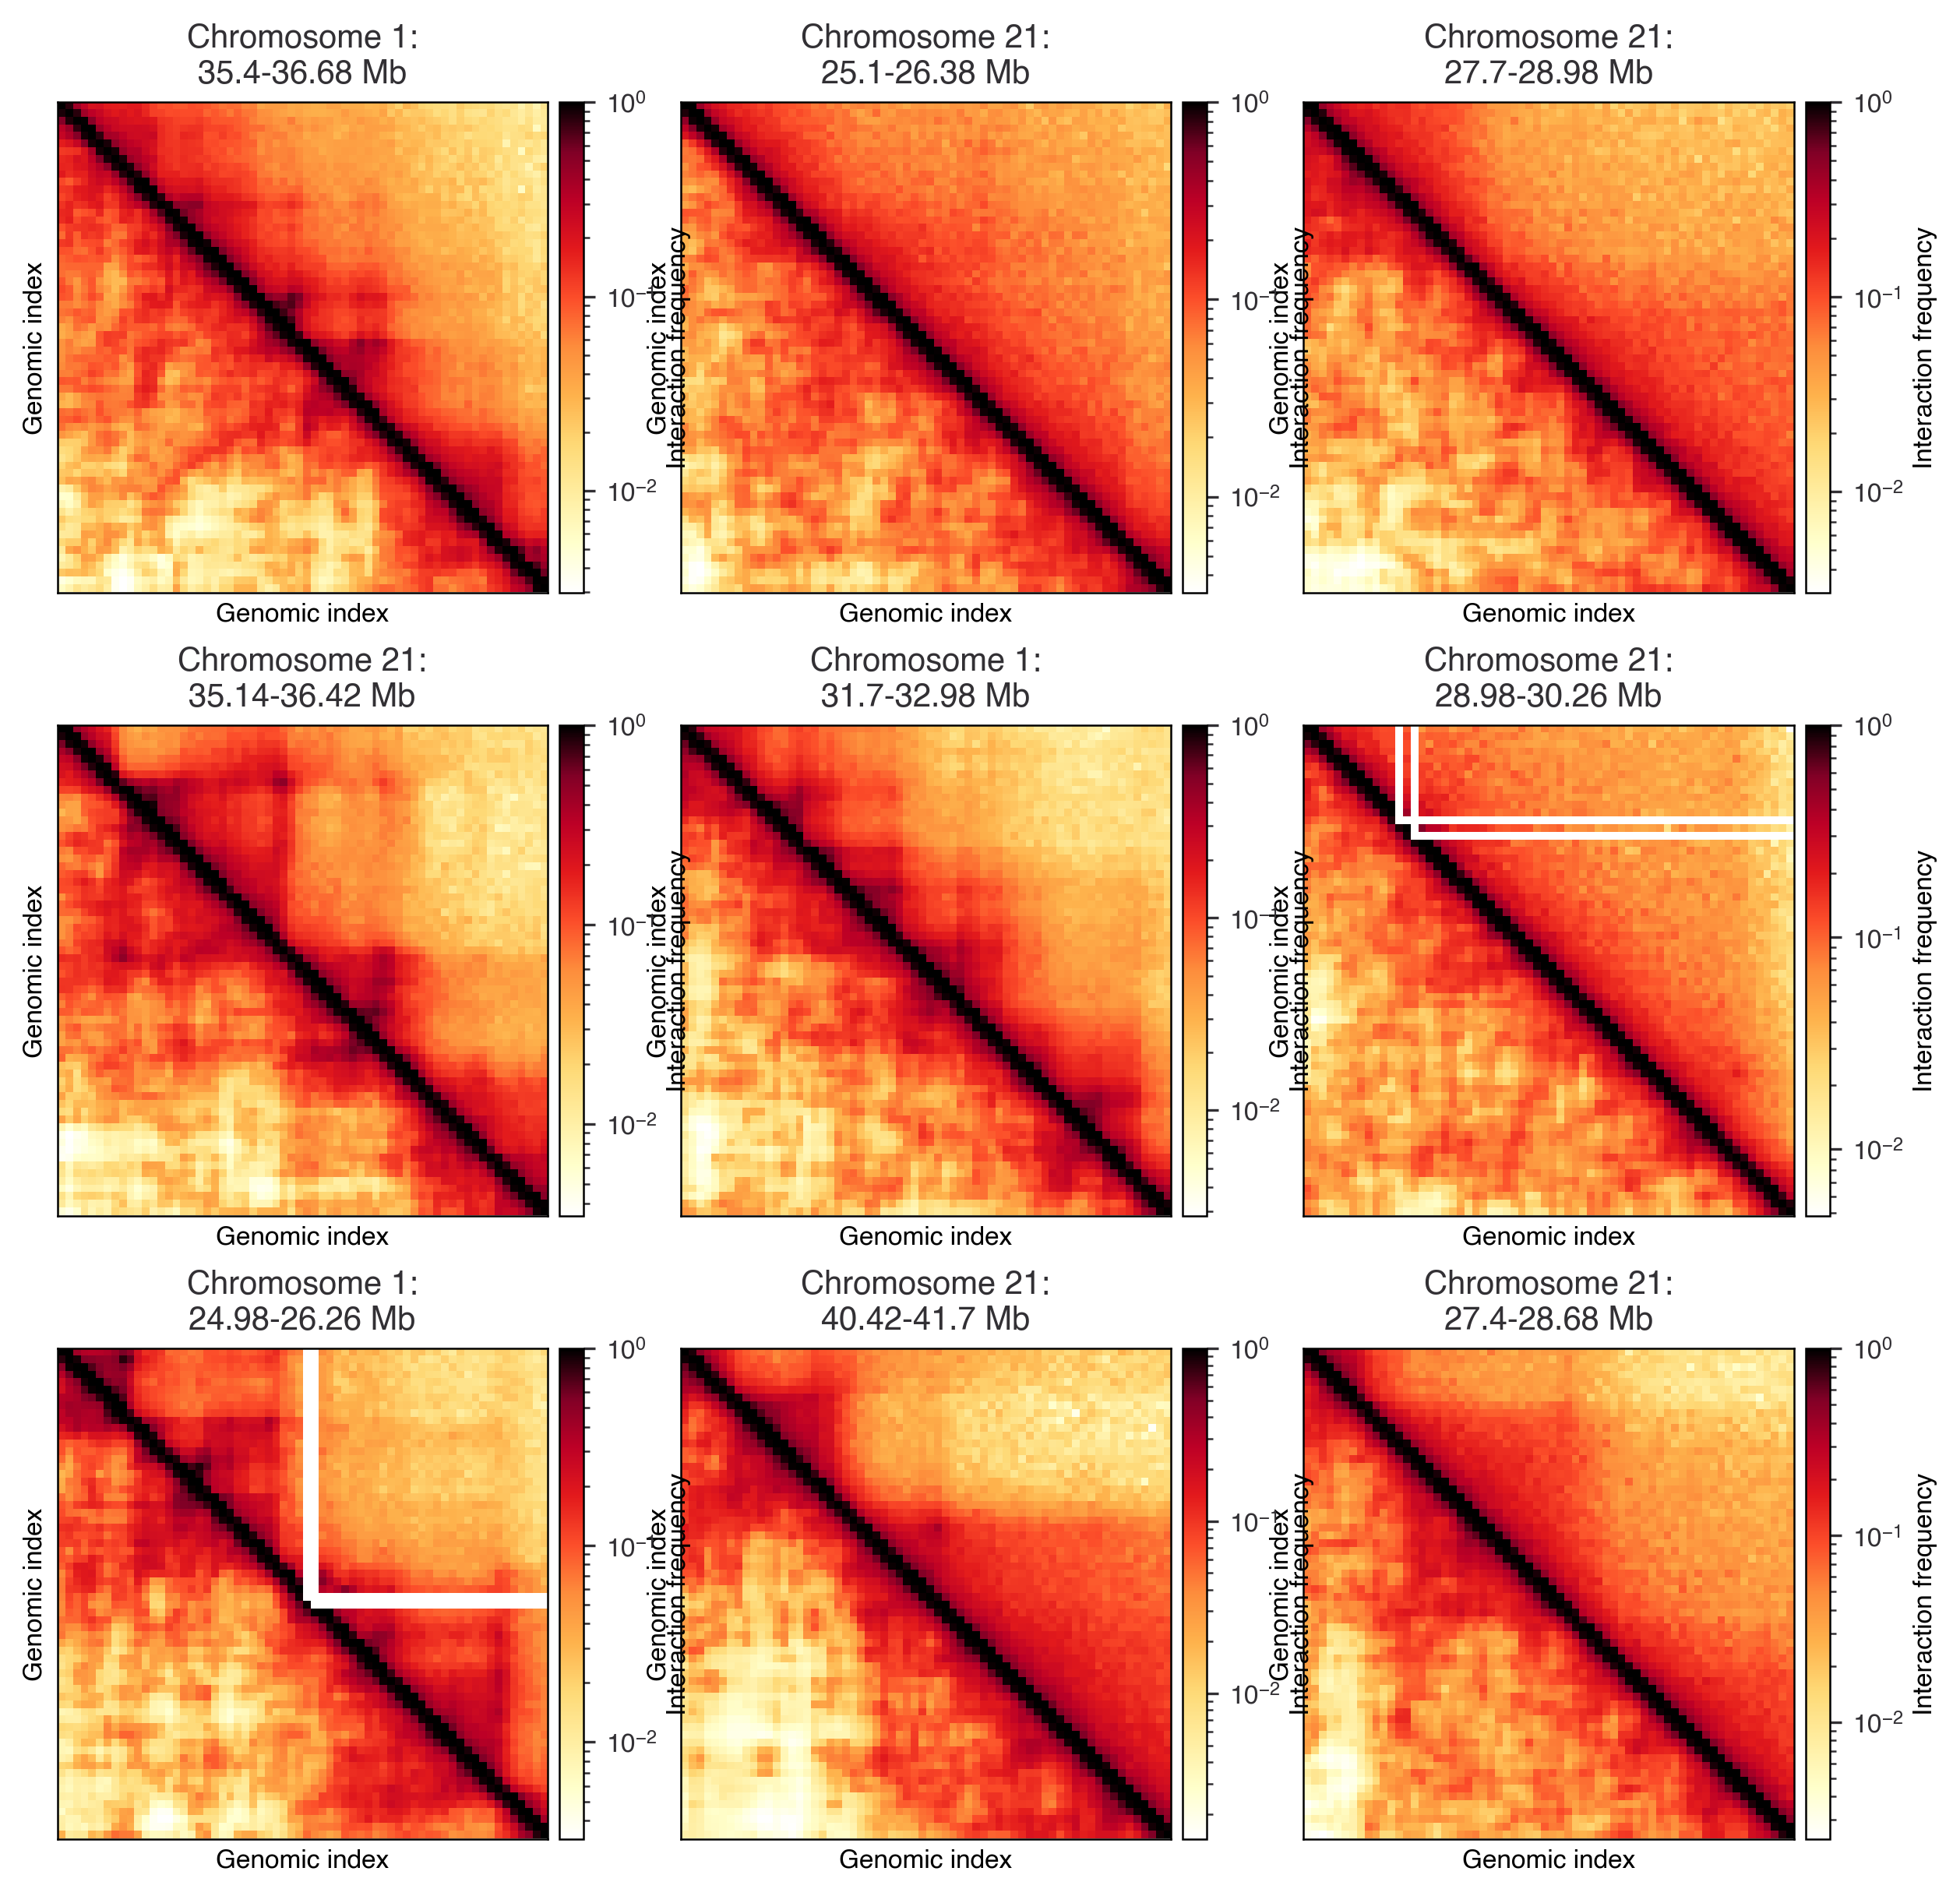

In [18]:
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8))
k=0
while k < 9:
    ax = axes[k//3,k%3]
    fig, ax, im, cbar = plot_region(all_gm_coord_files[-k-1],gm_hic,fig=fig,ax=ax)
    k+=1
    

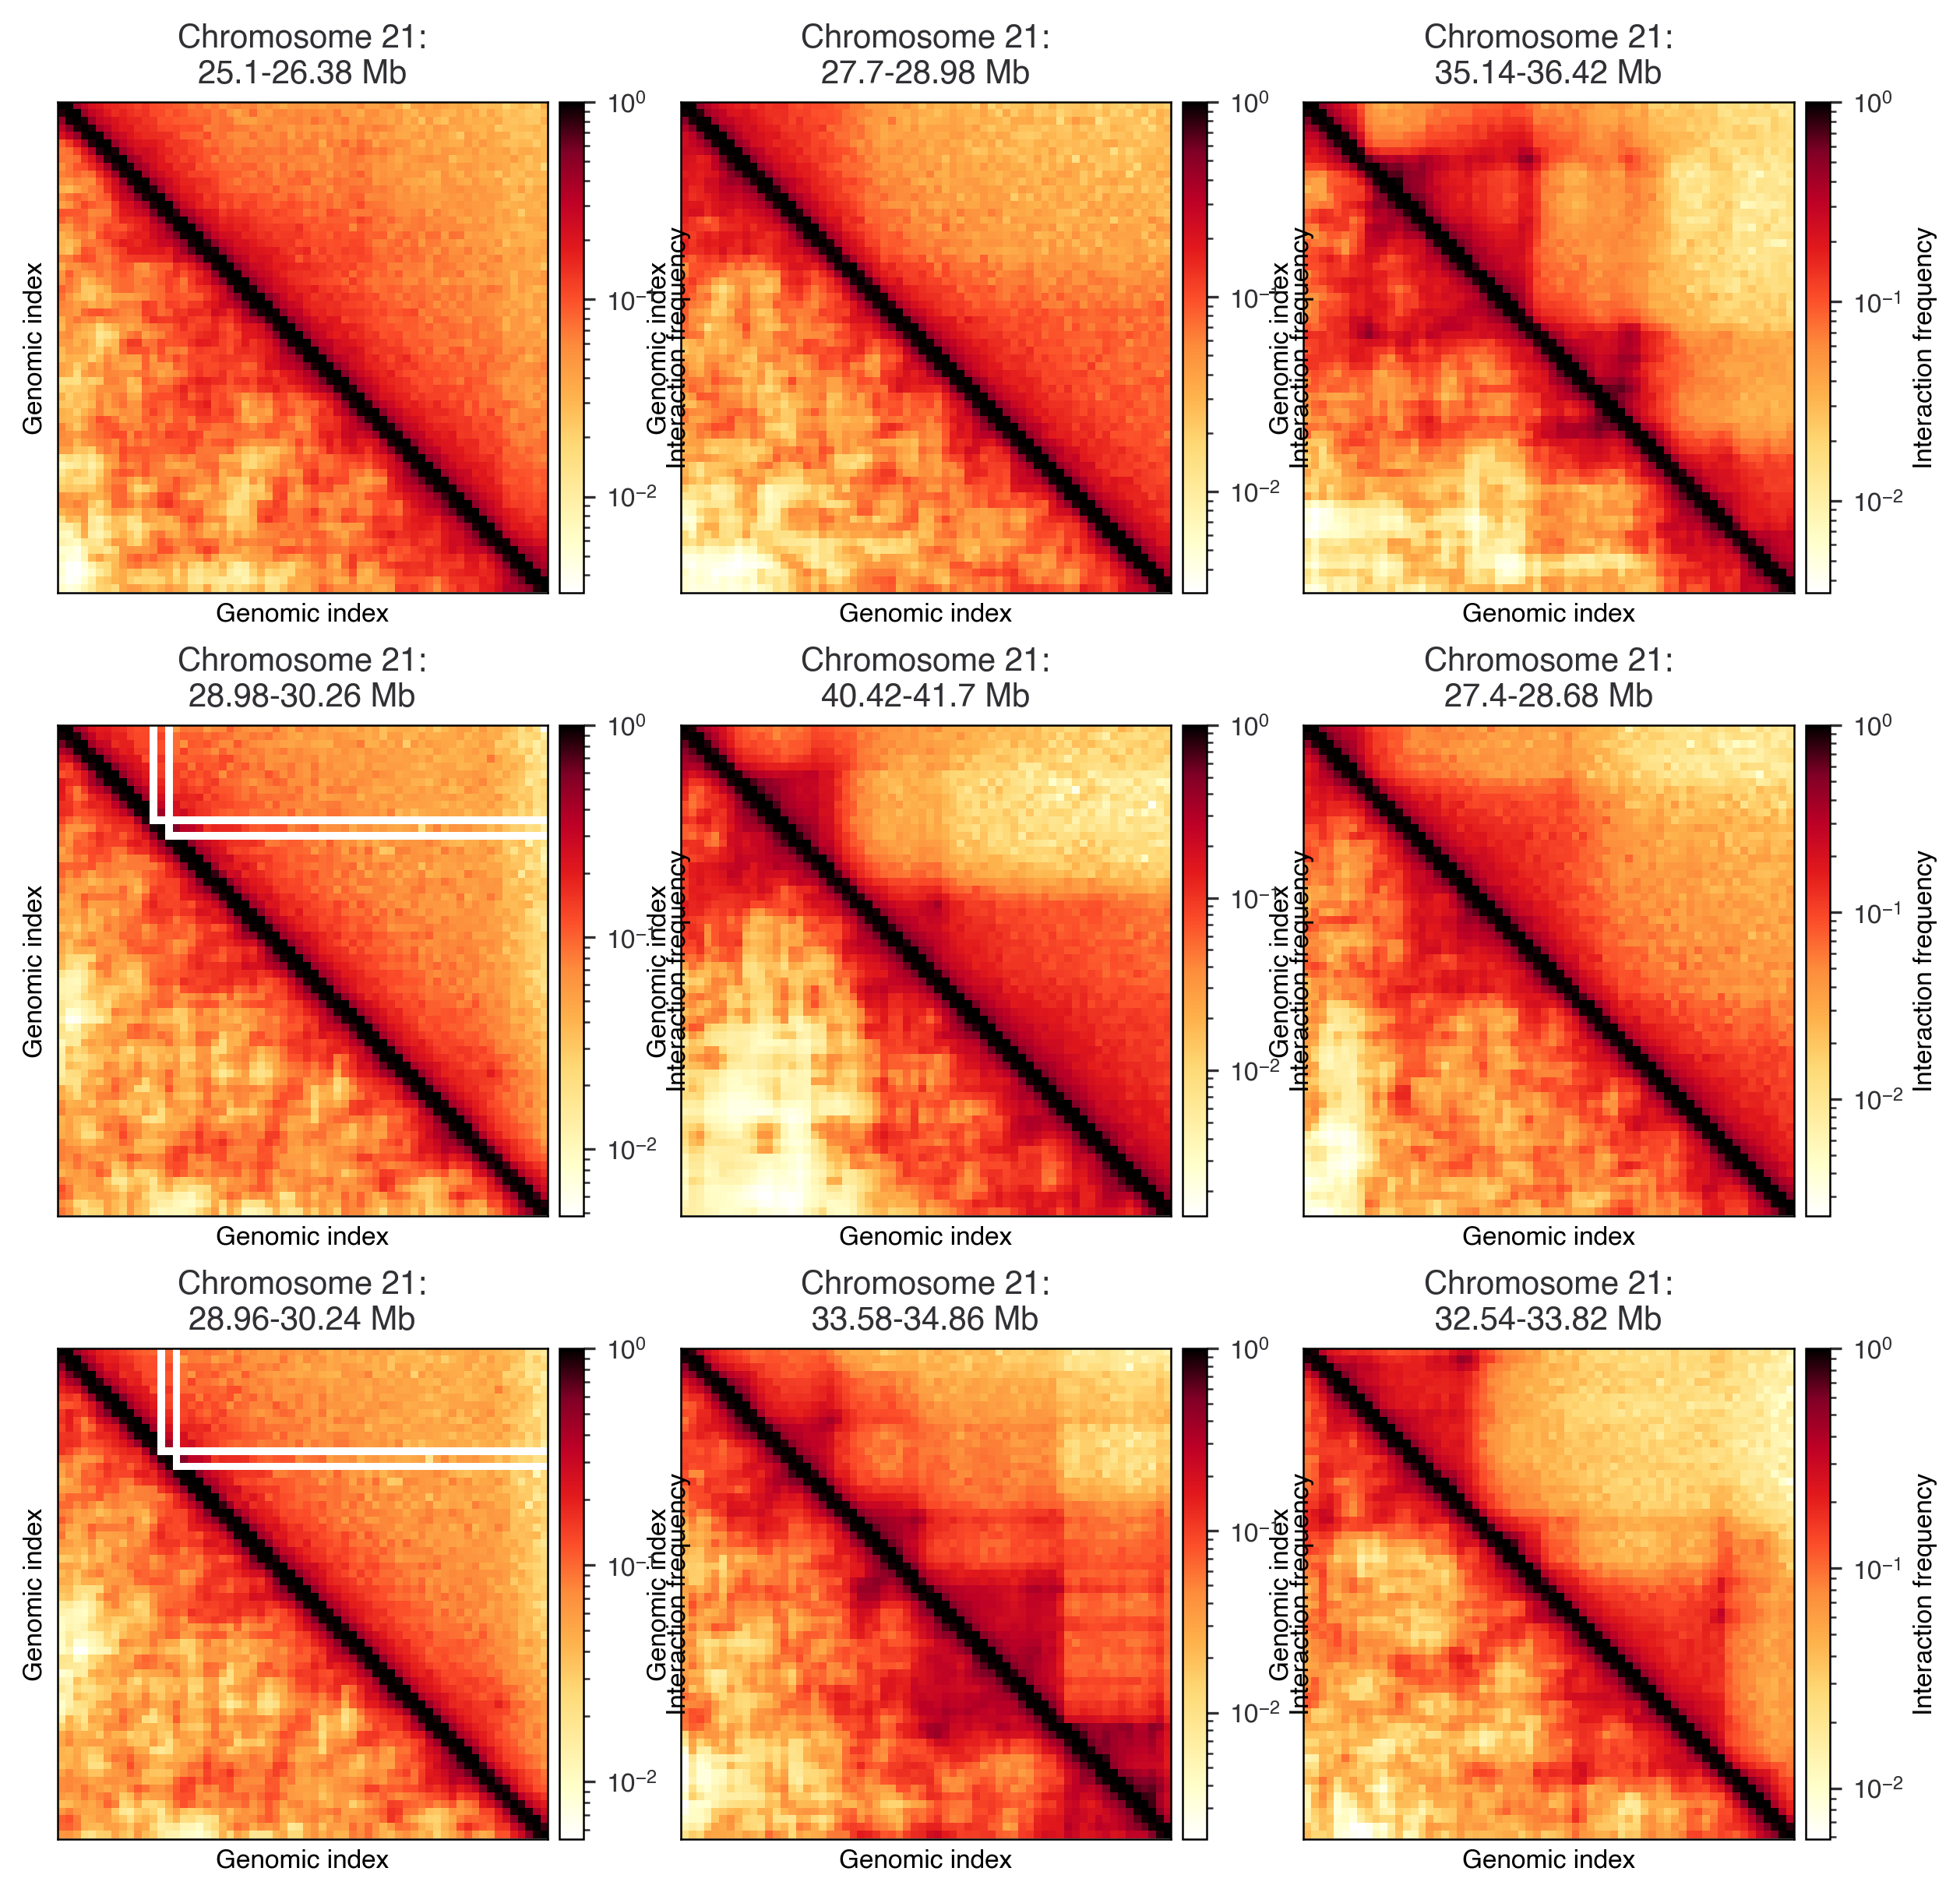

In [19]:
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8))
k=0
n=0
while k < 9:
    n+=1
    if not '_2' in all_gm_coord_files[-n]:
        continue
    ax = axes[k//3,k%3]
    fig, ax, im, cbar = plot_region(all_gm_coord_files[-n],gm_hic,fig=fig,ax=ax)
    k+=1
    

#### Compute all R-squared, correlation values

In [21]:
r2_dist = {}
corr_dist = {}
r2_prob = {}
corr_prob = {}
for cell_type,files,exp_hic in [('GM',all_gm_coord_files,gm_hic),('IMR',all_imr_coord_files,imr_hic)]:

    gen_median_dists = []
    gen_probs = []
    exp_probs = []
    exp_log_probs = []
    
    for f in files:
        
        # Determine the chromosome, region index, and genomic index
        chrom, region_idx, genomic_index = parse_filename(f)

        # Load the generated coordinates
        #coords = Coordinates(f)
        coords = Coordinates(
            config_ds.fetch_specific_coords(chrom,genomic_index)[1]
        )

        # Convert coordinates to distances and obtain the average contact probabilities
        dists = coords.distances
        gen_prob_map = conformations_to_probs(dists)

        # Load the experimental Hi-C interaction frequencies
        start = genomic_index
        stop = start + resolution * coords.num_beads
        exp_prob_map = exp_hic.fetch(chrom,start,stop)

        # Get the indices for the upper triangle of each set of data, excluding the diagonal
        n = coords.num_beads
        i,j = torch.triu_indices(n,n,1)

        #####
        # Place data into the respective lists

        # Interaction frequency
        exp_probs.append(exp_prob_map.prob_map[i,j])
        
        # Remove values associated with NaN Hi-C data
        valid_idx = torch.where(exp_probs[-1].isfinite())[0]
        exp_probs[-1] = exp_probs[-1][valid_idx]
        i,j = i[valid_idx], j[valid_idx]

        # Normalize the experimental interaction frequencies to nearest neighbors to
        # obtain contact probabilities consistent with our distance-to-probability 
        # conversion
        exp_probs[-1]/=  torch.nanmean(exp_prob_map.prob_map[range(n-1),range(1,n)])
        
        # Log probability
        exp_log_probs.append(exp_probs[-1].log10())
        
        # Generated probabilities
        gen_probs.append(gen_prob_map.prob_map[i,j])
        
        # Interactions with recorded probability 0 become undefined, so remove those points
        valid_idx = torch.where(exp_log_probs[-1].isfinite())[0]
        exp_log_probs[-1] = exp_log_probs[-1][valid_idx]
        i,j = i[valid_idx], j[valid_idx]

        # Generated distances
        gen_median_dists.append(dists.median.values[0,i,j])

    # Compute the desired statistics
    r2_dist[cell_type] = batch_r2(gen_median_dists,exp_log_probs)
    corr_dist[cell_type] = batch_corrcoef(gen_median_dists,exp_log_probs)
    r2_prob[cell_type] = batch_r2(gen_probs,exp_probs)
    corr_prob[cell_type] = batch_corrcoef(gen_probs,exp_probs)

    

#### Make the plots

In [22]:
def plot_hist(gm_data,imr_data,nbins=25,fig=None,ax=None,alpha=0.5):

    # Convert to numpy to improve speed in plt 
    gm_data = gm_data.cpu().numpy()
    imr_data = imr_data.cpu().numpy()

    # Create consistent bins for eaach data type
    minn = min(gm_data.min(),imr_data.min())
    maxx = max(gm_data.max(),imr_data.max())
    delta = (maxx-minn)/nbins
    bins = np.arange(minn,maxx+delta/2,delta)

    # Create the figure, if necessary
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    # Create the histogram
    ax.hist(gm_data,alpha=alpha,bins=bins,label='GM12878',edgecolor='none')
    ax.hist(imr_data,alpha=alpha,bins=bins,label='IMR-90',edgecolor='none')

    return fig, ax
    

    
    
    
    

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', 'I', 'M', 'N', 'R', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 42, 44, 48, 49, 53, 68, 69, 70, 71, 72, 73, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 44 glyphs after
I

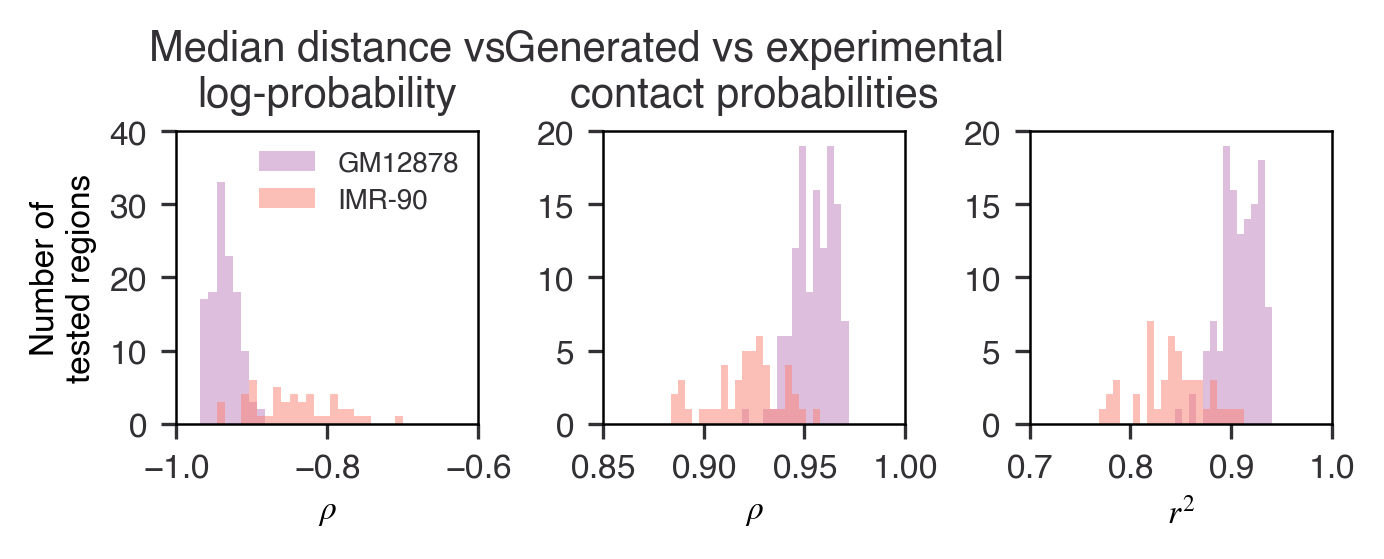

In [23]:
fig,axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(4.5,1.75))

xlabels = [
    '$\\rho$',
    '$\\rho$',
    '$r^2$'
]
titles = [
    'Median distance vs\nlog-probability',
    'Generated vs experimental\ncontact probabilities',
    ''
]

# R2-scores
for i,(r2_IMR,r2_GM) in enumerate([ (corr_dist['IMR'],corr_dist['GM']), (corr_prob['IMR'],corr_prob['GM']), (r2_prob['IMR'],r2_prob['GM']) ]):
    ax = axes[i]
    fig,ax = plot_hist(r2_GM,r2_IMR,fig=fig,ax=ax)
    ax.set_xlabel(xlabels[i])
    ax.set_title(titles[i])
    if i == 0:
        ax.set_ylabel('Number of\ntested regions')
        ax.legend(framealpha=0,loc='upper right',fontsize='small')

fig.savefig(save_folder+'HiCCorrelationR2_Tan.pdf',transparent=True)
    

In [25]:
for i,(r2_IMR,r2_GM) in enumerate([ (corr_dist['IMR'],corr_dist['GM']), (corr_prob['IMR'],corr_prob['GM']), (r2_prob['IMR'],r2_prob['GM']) ]):

    print(r2_GM.median())
    

tensor(-0.9375, dtype=torch.float64)
tensor(0.9561, dtype=torch.float64)
tensor(0.9105, dtype=torch.float64)


In [28]:
#for i,
#r2_dist['GM']
(corr_dist['IMR'],corr_dist['GM']), (corr_prob['IMR'],corr_prob['GM']), (r2_prob['IMR'],r2_prob['GM']) 
for i,f in enumerate(all_gm_coord_files):

    if 'sample_395_5.0_8.0_120_1.pt' in f:
        print(corr_dist['GM'][i],corr_prob['GM'][i], r2_prob['GM'][i])
    

tensor(-0.9579, dtype=torch.float64) tensor(0.9564, dtype=torch.float64) tensor(0.9120, dtype=torch.float64)
